In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/TrainAndValid/TrainAndValid.csv" , low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

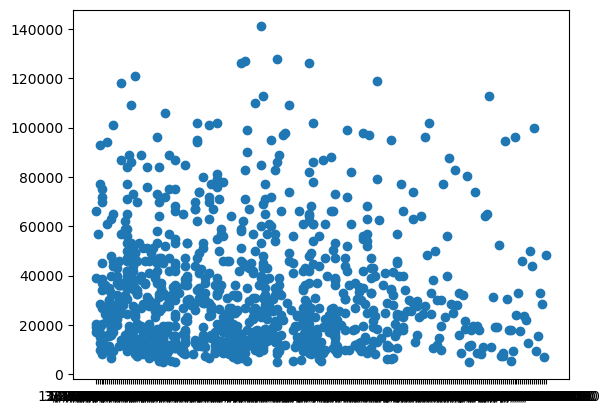

In [5]:
plt.scatter(y=df["SalePrice"][:1000],x=df["saledate"][:1000])

In [6]:
# it dosnt shows date as dateframe so...
df = pd.read_csv("data/TrainAndValid/TrainAndValid.csv",low_memory=False,parse_dates = ["saledate"])

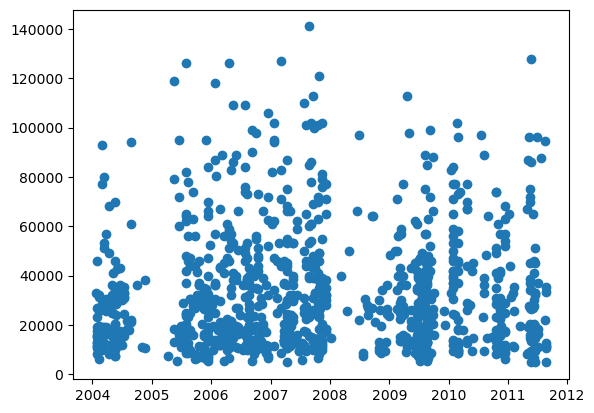

In [7]:
plt.scatter(y=df["SalePrice"][:1000],x=df["saledate"][:1000])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

## we should sort data series files and seperate dtae by y & m & d in columns

In [9]:
df.sort_values(by = ["saledate"],inplace=True)

In [10]:
df_temp = df.copy()

In [11]:
df_temp["saleyear"] = df_temp.saledate.dt.year
df_temp["salemonth"] = df_temp.saledate.dt.month
df_temp["saleday"] = df_temp.saledate.dt.day

## making categories for ML

In [12]:
for label , content in df_temp.items():
    if pd.api.types.is_string_dtype(df_temp[label].dtype):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [13]:
df_temp["Transmission"].cat.codes

205615    2
274835   -1
141296    7
212552   -1
62755     7
         ..
410879    7
412476   -1
411927   -1
407124    4
409203   -1
Length: 412698, dtype: int8

## save the df with categories features

In [14]:
# df_temp.to_csv("data/train_categorized.csv",index=False)

In [15]:
df_temp = pd.read_csv("data/train_categorized.csv",low_memory = False , parse_dates = ["saledate"])

In [16]:
df_temp.isnull().sum()/len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

## filling missing data

In [17]:
for label , content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
            df_temp[label + " is missing"] = pd.isnull(content)
            df_temp[label] = content.fillna(content.median())

In [18]:
df_temp["MachineHoursCurrentMeter is missing"].value_counts()

MachineHoursCurrentMeter is missing
True     265194
False    147504
Name: count, dtype: int64

In [19]:
df_temp.isna().sum()/len(df_temp)

SalesID                                0.000000
SalePrice                              0.000000
MachineID                              0.000000
ModelID                                0.000000
datasource                             0.000000
auctioneerID                           0.000000
YearMade                               0.000000
MachineHoursCurrentMeter               0.000000
UsageBand                              0.821492
saledate                               0.000000
fiModelDesc                            0.000000
fiBaseModel                            0.000000
fiSecondaryDesc                        0.340993
fiModelSeries                          0.857845
fiModelDescriptor                      0.818715
ProductSize                            0.524851
fiProductClassDesc                     0.000000
state                                  0.000000
ProductGroup                           0.000000
ProductGroupDesc                       0.000000
Drive_System                           0

In [20]:
for label , content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[label+" is missing"] = pd.isnull(content)
        df_temp[label] = pd.Categorical(content).codes+1

In [21]:
df_temp.isnull().any()

SalesID                         False
SalePrice                       False
MachineID                       False
ModelID                         False
datasource                      False
                                ...  
Backhoe_Mounting is missing     False
Blade_Type is missing           False
Travel_Controls is missing      False
Differential_Type is missing    False
Steering_Controls is missing    False
Length: 103, dtype: bool

## fitting model

In [22]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=21)

In [23]:
%%time
# model.fit(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"]) # 27 mins

CPU times: total: 0 ns
Wall time: 0 ns


## spliting data

In [24]:
train_data = df_temp[df_temp["saleyear"] < 2012]
val_data = df_temp[df_temp["saleyear"] >= 2012]
x_train , y_train = train_data.drop("SalePrice",axis=1),train_data.SalePrice
x_val , y_val = val_data.drop("SalePrice",axis=1),val_data.SalePrice

In [25]:
x_train.shape , y_val.shape, df_temp.shape

((401125, 102), (11573,), (412698, 103))

In [26]:
from sklearn.metrics import root_mean_squared_log_error , r2_score , mean_absolute_error , mean_squared_error
rmsle = root_mean_squared_log_error

In [27]:
def validation_report(y_test , y_preds):
    scores = {"rmsle is : " : rmsle(y_test,y_preds),
              " mean_absolute_error is : " :  mean_absolute_error(y_test , y_preds),
              "mean_squared_error is : " : mean_squared_error(y_test , y_preds),
              "r2 is :" : r2_score(y_test , y_preds)
             }
    return scores

In [28]:
# reducing x_train by max_samples
# %timeit
# model = RandomForestRegressor(random_state=21 , max_samples =10000 )
# model.fit(x_train,y_train)

In [29]:
# y_preds = model.predict(x_val)

In [30]:
# validation_report(y_val , y_preds) # by x_train[-10000:],y_train[-10000:]
# RMSLE = 0.285

In [31]:
# validation_report(y_val , y_preds) # by max_samples
#RMSLE = 0.294

## hyper parameters

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [33]:
# # random_grid = {'max_depth': [10, 20, 30, 40, 50, 100, 110, None],
#                'max_features': [0.5,1,'auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [130, 180, 230]}
# # rcv = RandomizedSearchCV(model,random_grid,n_iter=3,verbose=2,random_state=3,cv=3)
# # rcv.fit(x_train,y_train)

In [34]:
# y_preds = rcv.predict(x_val)

In [35]:
# validation_report(y_val,y_preds) # by randomizedcv
#RMSLE = 0.293

## train full data with tuned hyperparameters

In [36]:
# model_pro = RandomForestRegressor(n_estimators=40,
#                                  min_samples_leaf=1,
#                                  min_samples_split=14,
#                                  max_features=0.5,
#                                  max_samples=None,
#                                  random_state=42)
# model_pro.fit(x_train,y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      random_state=42)

In [37]:
# y_preds = model_pro.predict(x_val)

In [47]:
# validation_report(y_val,y_preds) # by best randomizedcv and full data
#RMSLE = 0.246

{'rmsle is : ': 0.24633298777862547,
 ' mean_absolute_error is : ': 5979.688239400049,
 'mean_squared_error is : ': 81482533.11468442,
 'r2 is :': 0.8813716616684798}

## save model

In [53]:
import joblib
# joblib.dump(model_pro,"models/model1_RMSLE_0.246.joblib")

['models/model1_RMSLE_0.246.joblib']

In [54]:
load_model_pro = joblib.load("models/model1_RMSLE_0.246.joblib")

## test the Test.csv

In [39]:
test_data = pd.read_csv('data/Test.csv',parse_dates = ["saledate"] , low_memory=False)

In [40]:
test_data["saleyear"] = test_data.saledate.dt.year
test_data["salemonth"] = test_data.saledate.dt.month
test_data["saleday"] = test_data.saledate.dt.day

In [41]:
for label , content in test_data.items():
    if pd.api.types.is_string_dtype(test_data[label].dtype):
        test_data[label] = content.astype("category").cat.as_ordered()

In [42]:
test_data["auctioneerID is missing"] = False

In [43]:
for label , content in test_data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
            print(label)
            test_data[label + " is missing"] = pd.isnull(content)
            test_data[label] = content.fillna(content.median())

MachineHoursCurrentMeter


In [44]:
for label , content in test_data.items():
    if not pd.api.types.is_numeric_dtype(content):
        test_data[label+" is missing"] = pd.isnull(content)
        test_data[label] = pd.Categorical(content).codes+1

In [45]:
# test_preds = model_pro.predict(test_data)

In [48]:
# finalreport1 = pd.DataFrame(test_data.SalesID,columns = ["SalesID","SalePrice"])
# finalreport1.SalePrice = test_preds
# finalreport1.SalesID = test_data.SalesID
# finalreport1

In [49]:
# finalreport1.to_csv("TestReport1.csv",index=False)

## features importance

In [107]:
def features_importance(columns,features,n=20):
    bardf= pd.DataFrame({"features":x_train.columns,"features_importance":load_model_pro.feature_importances_}).sort_values("features_importance" , ascending=False).reset_index(drop=True)    
    ax = plt.subplot()
    ax.barh(bardf["features"][:n],bardf["features_importance"][:n])
    ax.invert_yaxis()

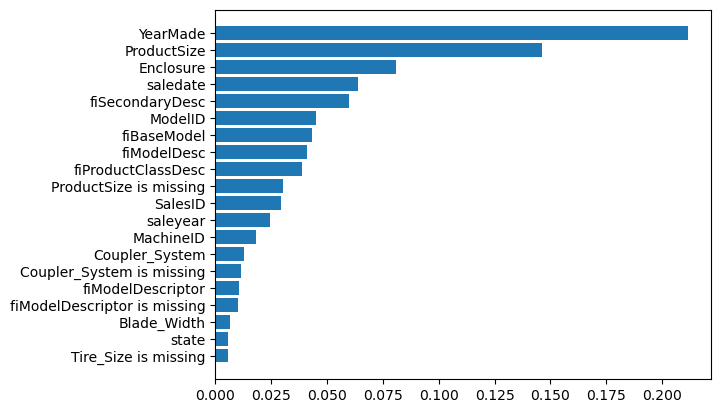

In [108]:
features_importance(x_train.columns,load_model_pro.feature_importances_)

In [56]:
load_model_pro.feature_importances_

array([2.92923512e-02, 1.81457218e-02, 4.49463445e-02, 9.70637355e-04,
       3.10105650e-03, 2.11517776e-01, 2.61263085e-03, 9.41281637e-04,
       6.37896093e-02, 4.10228397e-02, 4.31413863e-02, 5.98708784e-02,
       4.33776143e-03, 1.07509337e-02, 1.46426211e-01, 3.87620956e-02,
       5.71577997e-03, 3.19331265e-03, 2.88430683e-03, 3.71543192e-03,
       8.06532757e-02, 6.23530337e-04, 3.76589626e-05, 8.11785062e-04,
       2.25008326e-04, 8.23786225e-04, 5.13362923e-04, 2.07407311e-03,
       6.53552890e-03, 3.05370775e-04, 2.43079451e-03, 3.26774980e-03,
       4.78041617e-03, 5.17736005e-03, 2.27566553e-04, 4.98004221e-03,
       3.72886577e-03, 9.41070422e-04, 1.26479861e-02, 3.78823367e-04,
       3.22266719e-03, 7.30046318e-04, 9.75227484e-04, 3.07592749e-03,
       5.65846773e-04, 7.92423512e-04, 3.56551835e-04, 1.17634636e-04,
       1.77899026e-03, 1.25037965e-03, 2.85682111e-04, 2.11846697e-04,
       2.42548299e-02, 4.53437304e-03, 5.36963743e-03, 2.18128096e-04,
      